# Predicting the weather

In this notebook I'm attempting to predict the temperature for a station in the Netherlands, specifically at De Bilt. Data comes from https://projects.knmi.nl/klimatologie/uurgegevens/selectie.cgi and is freely available on the web. I took data from Jan 1, 2017 until Jan 2, 2020 on an hourly basis.

I will do the following:

- Look at the data first
- Try to predict the temperature in De Bilt without any features
- Try to predict the temperature in De Bilt with features
- Try to predict the temperature in multiple stations using shared features

The motivation behind this is a similar problem at work, I can't however use data as it's sensitive data (and I'm also not sure it will work), so I'm using this data to play around with.

In [59]:
import pandas as pd
import tensorflow as tf
import numpy as np

## 1. Getting the data

In [80]:
hourly_data = pd.read_csv("KNMI_20200102_hourly.txt",sep=",",header=0,skiprows=list(range(32))+[33],skipinitialspace=True)

In [81]:
hourly_data

,# STN,YYYYMMDD,HH,DD,FH,FF,FX,T,T10,TD,...,VV,N,U,WW,IX,M,R,S,O,Y
0,260,20170101,1,200,40,40,60,12,NaN,12,...,5,9,99,32.0,7,1,1,0,0,0
1,260,20170101,2,200,40,40,70,12,NaN,12,...,3,9,99,34.0,7,1,0,0,0,0
2,260,20170101,3,210,40,40,70,13,NaN,12,...,9,9,99,32.0,7,1,0,0,0,0
3,260,20170101,4,210,40,40,70,14,NaN,13,...,11,8,98,20.0,7,1,0,0,0,0
4,260,20170101,5,210,40,30,70,15,NaN,14,...,18,8,98,10.0,7,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26323,260,20200102,20,190,60,50,100,62,NaN,49,...,65,8,91,NaN,5,0,0,0,0,0
26324,260,20200102,21,190,50,40,90,64,NaN,49,...,66,8,89,NaN,5,0,0,0,0,0
26325,260,20200102,22,190,50,50,90,68,NaN,50,...,65,8,88,NaN,5,0,0,0,0,0
26326,260,20200102,23,200,50,40,90,71,NaN,53,...,65,8,88,NaN,5,0,0,0,0,0


In [82]:
# Description
!head -n 35 KNMI_20200102_hourly.txt

# BRON: KONINKLIJK NEDERLANDS METEOROLOGISCH INSTITUUT (KNMI)
# Opmerking: door stationsverplaatsingen en veranderingen in waarneemmethodieken zijn deze tijdreeksen van uurwaarden mogelijk inhomogeen! Dat betekent dat deze reeks van gemeten waarden niet geschikt is voor trendanalyse. Voor studies naar klimaatverandering verwijzen we naar de gehomogeniseerde reeks maandtemperaturen van De Bilt <http://www.knmi.nl/klimatologie/onderzoeksgegevens/homogeen_260/index.html> of de Centraal Nederland Temperatuur <http://www.knmi.nl/klimatologie/onderzoeksgegevens/CNT/>.
# 
# 
# STN      LON(east)   LAT(north)     ALT(m)  NAME
# 260:         5.180       52.100       1.90  DE BILT
# 
# YYYYMMDD = datum (YYYY=jaar,MM=maand,DD=dag); 
# HH       = tijd (HH=uur, UT.12 UT=13 MET, 14 MEZT. Uurvak 05 loopt van 04.00 UT tot 5.00 UT; 
# DD       = Windrichting (in graden) gemiddeld over de laatste 10 minuten van het afgelopen uur (360=noord, 90=oost, 180=zuid, 270=west, 0=windstil 990=veranderlijk. Zie h

In [83]:
hourly_data.columns

Index(['# STN', 'YYYYMMDD', 'HH', 'DD', 'FH', 'FF', 'FX', 'T', 'T10', 'TD',
       'SQ', 'Q', 'DR', 'RH', 'P', 'VV', 'N', 'U', 'WW', 'IX', 'M', 'R', 'S',
       'O', 'Y'],
      dtype='object')

In [84]:
hourly_data

,# STN,YYYYMMDD,HH,DD,FH,FF,FX,T,T10,TD,...,VV,N,U,WW,IX,M,R,S,O,Y
0,260,20170101,1,200,40,40,60,12,NaN,12,...,5,9,99,32.0,7,1,1,0,0,0
1,260,20170101,2,200,40,40,70,12,NaN,12,...,3,9,99,34.0,7,1,0,0,0,0
2,260,20170101,3,210,40,40,70,13,NaN,12,...,9,9,99,32.0,7,1,0,0,0,0
3,260,20170101,4,210,40,40,70,14,NaN,13,...,11,8,98,20.0,7,1,0,0,0,0
4,260,20170101,5,210,40,30,70,15,NaN,14,...,18,8,98,10.0,7,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26323,260,20200102,20,190,60,50,100,62,NaN,49,...,65,8,91,NaN,5,0,0,0,0,0
26324,260,20200102,21,190,50,40,90,64,NaN,49,...,66,8,89,NaN,5,0,0,0,0,0
26325,260,20200102,22,190,50,50,90,68,NaN,50,...,65,8,88,NaN,5,0,0,0,0,0
26326,260,20200102,23,200,50,40,90,71,NaN,53,...,65,8,88,NaN,5,0,0,0,0,0


In [85]:
hourly_data['HH'] = hourly_data['HH'] - 1
hourly_data['HH'] = hourly_data.HH.astype(str).str.pad(2,fillchar='0')

In [86]:
hourly_data.index = pd.to_datetime(hourly_data['YYYYMMDD'].astype(str) + ' ' + hourly_data['HH'],format='%Y%m%d %H')

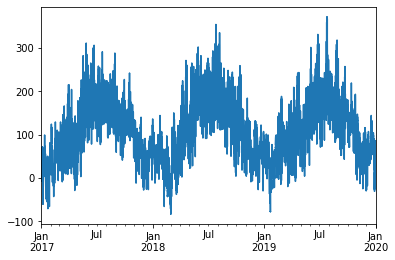

In [87]:
hourly_data['T'].plot()

In [88]:
hourly_data

,# STN,YYYYMMDD,HH,DD,FH,FF,FX,T,T10,TD,...,VV,N,U,WW,IX,M,R,S,O,Y
2017-01-01 00:00:00,260,20170101,00,200,40,40,60,12,NaN,12,...,5,9,99,32.0,7,1,1,0,0,0
2017-01-01 01:00:00,260,20170101,01,200,40,40,70,12,NaN,12,...,3,9,99,34.0,7,1,0,0,0,0
2017-01-01 02:00:00,260,20170101,02,210,40,40,70,13,NaN,12,...,9,9,99,32.0,7,1,0,0,0,0
2017-01-01 03:00:00,260,20170101,03,210,40,40,70,14,NaN,13,...,11,8,98,20.0,7,1,0,0,0,0
2017-01-01 04:00:00,260,20170101,04,210,40,30,70,15,NaN,14,...,18,8,98,10.0,7,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-02 19:00:00,260,20200102,19,190,60,50,100,62,NaN,49,...,65,8,91,NaN,5,0,0,0,0,0
2020-01-02 20:00:00,260,20200102,20,190,50,40,90,64,NaN,49,...,66,8,89,NaN,5,0,0,0,0,0
2020-01-02 21:00:00,260,20200102,21,190,50,50,90,68,NaN,50,...,65,8,88,NaN,5,0,0,0,0,0
2020-01-02 22:00:00,260,20200102,22,200,50,40,90,71,NaN,53,...,65,8,88,NaN,5,0,0,0,0,0


# Simple RNN, temperature only

In [ ]:
data = df['T']
data.index = df['Date Time']
data.head()